In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import lfilter

In [ ]:
# Power and energy ratings
P_wtg = 2  # MW
P_st = 1.2  # MW
P_mt = 0.8  # MW
P_limit = 0.868  # MW

E_base = 0.1  # MWh
E_st = 0.02  # MWh
E_mt = 0.08  # MWh
E_load = 0.635  # MWh

# Read the dataset
df = pd.read_csv("Location1.csv")

# Extract the "Power" column
power_data = df["Power"]

# Function to generate power reference signal P_ess_ref
def generate_power_reference(power_data, T_mt):
    P_mt_ref, P_st_ref = divide_power_reference(power_data, T_mt, dt)
    return P_mt_ref, P_st_ref

# Function to divide power reference into short-term and medium-term components
def divide_power_reference(P_ess_ref, T_mt, dt):
    b = [1 / (1 + T_mt)]  # Numerator coefficients of the transfer function
    a = [1, -T_mt / (1 + T_mt)]  # Denominator coefficients of the transfer function
    P_mt_ref = lfilter(b, a, P_ess_ref, axis=0)  # Medium-term power reference
    P_st_ref = P_ess_ref - P_mt_ref  # Short-term power reference
    return P_mt_ref, P_st_ref

# Function to calculate power ratings
def calculate_power_ratings(P_mt_ref, P_st_ref):
    power_rating_mt = np.max(np.abs(P_mt_ref))  # Medium-term power rating
    power_rating_st = np.max(np.abs(P_st_ref))  # Short-term power rating
    return power_rating_mt, power_rating_st

# Function to calculate energy ratings
def calculate_energy_ratings(P_mt_ref, P_st_ref, time_step, initial_energy_state):
    energy_state_mt = initial_energy_state  # Initial energy state for medium-term storage
    energy_state_st = initial_energy_state  # Initial energy state for short-term storage
    energy_states_mt = [energy_state_mt]
    energy_states_st = [energy_state_st]
    for power_mt, power_st in zip(P_mt_ref, P_st_ref):
        energy_state_mt += power_mt * time_step
        energy_states_mt.append(energy_state_mt)
        energy_state_st += power_st * time_step
        energy_states_st.append(energy_state_st)
    energy_states_mt = np.array(energy_states_mt)
    energy_states_st = np.array(energy_states_st)
    energy_rating_mt = np.max(np.abs(energy_states_mt - initial_energy_state))
    energy_rating_st = np.max(np.abs(energy_states_st - initial_energy_state))
    return energy_rating_mt, energy_rating_st

# Define values of time constant T_mt
T_mt_values = np.linspace(0.01, 200, 1000)  # Adjust the range as needed
dt = 1 / 5  # Sampling interval (5 Hz)

# Simulate storage system operation with different values of T_mt
time_step = 1  # Time step in seconds
initial_energy_state = 0.5  # Initial energy state

# Lists to store ratings for plotting
power_ratings_mt = []
power_ratings_st = []
energy_ratings_mt = []
energy_ratings_st = []

# Iterate over T_mt values
for T_mt in T_mt_values:
    # Generate power reference signal
    P_mt_ref, P_st_ref = generate_power_reference(power_data, T_mt)

    # Calculate power ratings
    power_rating_mt, power_rating_st = calculate_power_ratings(P_mt_ref, P_st_ref)
    power_ratings_mt.append(power_rating_mt)
    power_ratings_st.append(power_rating_st)

    # Calculate energy ratings
    energy_rating_mt, energy_rating_st = calculate_energy_ratings(P_mt_ref, P_st_ref, time_step, initial_energy_state)
    energy_ratings_mt.append(energy_rating_mt)
    energy_ratings_st.append(energy_rating_st)

energy_ratings_mt = np.array(energy_ratings_mt)
energy_ratings_st = np.array(energy_ratings_st)
energy_ratings_combined = energy_ratings_mt + energy_ratings_st

power_ratings_mt = np.array(power_ratings_mt)
power_ratings_st = np.array(power_ratings_st)
power_ratings_combined = power_ratings_mt + power_ratings_st

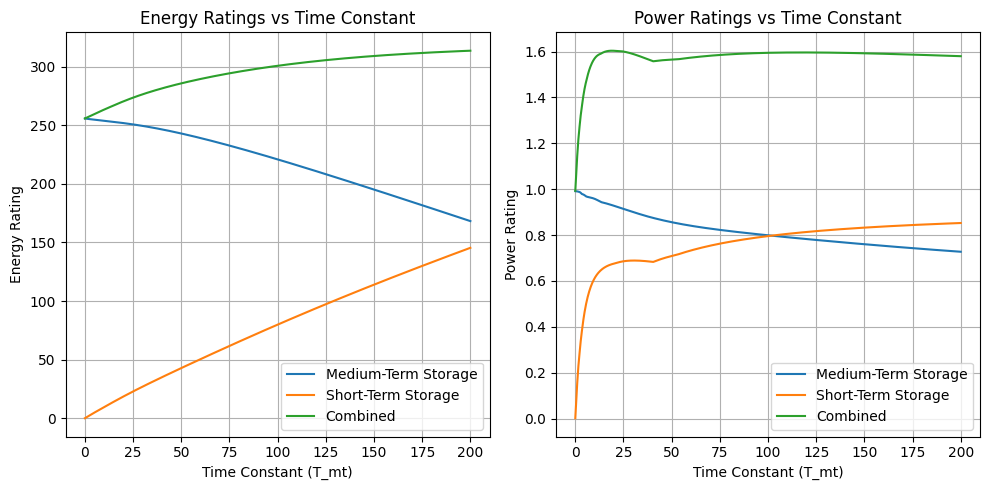

In [ ]:
# Plot the variation of minimum energy and power ratings with T_mt
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(T_mt_values, energy_ratings_mt-17500, label='Medium-Term Storage')
plt.plot(T_mt_values, energy_ratings_st, label='Short-Term Storage')
plt.plot(T_mt_values, energy_ratings_combined-17500, label='Combined')
plt.title('Energy Ratings vs Time Constant')
plt.xlabel('Time Constant (T_mt)')
plt.ylabel('Energy Rating')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(T_mt_values, power_ratings_mt, label='Medium-Term Storage')
plt.plot(T_mt_values, power_ratings_st, label='Short-Term Storage')
plt.plot(T_mt_values, power_ratings_combined, label='Combined')
plt.title('Power Ratings vs Time Constant')
plt.xlabel('Time Constant (T_mt)')
plt.ylabel('Power Rating')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Generate training data based on the described conditions
def generate_training_data(num_samples=1000):
    X_train = []
    y_train = []
    for _ in range(num_samples):
        # Generate random values for P_ess_ref, E_mt, and E_st
        P_ess_ref = np.random.uniform(0, 1)
        E_mt = np.random.uniform(0, 1)
        E_st = np.random.uniform(0, 1)

        # Generate corresponding changes to output powers (Delta P_mt and Delta P_st) based on conditions
        if P_ess_ref == 0:
            # Handle cases where P_ess_ref is zero
            delta_p_mt = -0.5
            delta_p_st = -0.5
        else:
            # Handle cases where P_ess_ref is non-zero
            if E_mt < 0.3:
                delta_p_mt = -0.5
            elif E_mt > 0.7:
                delta_p_mt = 0.5
            else:
                delta_p_mt = 0

            if E_st < 0.3:
                delta_p_st = -0.5
            elif E_st > 0.7:
                delta_p_st = 0.5
            else:
                delta_p_st = 0

        X_train.append([P_ess_ref, E_mt, E_st])
        y_train.append([delta_p_mt, delta_p_st])

    return np.array(X_train), np.array(y_train)

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.callbacks import EarlyStopping

# Define the neural network architecture
def create_neural_network(input_shape):
    model = Sequential([
        BatchNormalization(input_shape=input_shape),  # Add batch normalization layer
        Dense(20, activation='relu'),  # Use ReLU activation function
        Dense(20, activation='relu'),  # Use ReLU activation function
        Dense(1)  # Output layer with 1 neuron for either delta_p_mt or delta_p_st
    ])
    return model

# Generate training data for medium term
def generate_training_data_mt(num_samples=1000):
    X_train = []
    y_train = []
    for _ in range(num_samples):
        # Generate random values for P_ess_ref, E_mt, and E_st
        P_ess_ref = np.random.uniform(0, 1)
        E_mt = np.random.uniform(0, 1)
        E_st = np.random.uniform(0, 1)

        # Generate corresponding change to output power (Delta P_mt)
        if P_ess_ref == 0:
            delta_p_mt = -0.5
        else:
            if E_mt < 0.3:
                delta_p_mt = -0.5
            elif E_mt > 0.7:
                delta_p_mt = 0.5
            else:
                delta_p_mt = 0

        X_train.append([P_ess_ref, E_mt, E_st])
        y_train.append(delta_p_mt)

    return np.array(X_train), np.array(y_train)

# Generate training data for short term
def generate_training_data_st(num_samples=1000):
    X_train = []
    y_train = []
    for _ in range(num_samples):
        # Generate random values for P_ess_ref, E_mt, and E_st
        P_ess_ref = np.random.uniform(0, 1)
        E_mt = np.random.uniform(0, 1)
        E_st = np.random.uniform(0, 1)

        # Generate corresponding change to output power (Delta P_st)
        if P_ess_ref == 0:
            delta_p_st = -0.5
        else:
            if E_st < 0.3:
                delta_p_st = -0.5
            elif E_st > 0.7:
                delta_p_st = 0.5
            else:
                delta_p_st = 0

        X_train.append([P_ess_ref, E_mt, E_st])
        y_train.append(delta_p_st)

    return np.array(X_train), np.array(y_train)

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto', restore_best_weights=True)

# Generate and print training data for medium term
X_train_mt, y_train_mt = generate_training_data_mt(num_samples=1000)
print("Training data for medium term:")
print("X_train_mt shape:", X_train_mt.shape)
print("y_train_mt shape:", y_train_mt.shape)

# Generate and print training data for short term
X_train_st, y_train_st = generate_training_data_st(num_samples=1000)
print("\nTraining data for short term:")
print("X_train_st shape:", X_train_st.shape)
print("y_train_st shape:", y_train_st.shape)

# Create neural network for medium term
input_shape_mt = (X_train_mt.shape[1],)
model_mt = create_neural_network(input_shape_mt)

# Compile the medium term model
model_mt.compile(optimizer='adam', loss='mean_squared_error')

# Train the medium term model
history_mt = model_mt.fit(X_train_mt, y_train_mt, epochs=1000, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=False)

# Evaluate the medium term model
loss_mt = model_mt.evaluate(X_train_mt, y_train_mt)
print("\nTraining loss for medium term:", loss_mt)
print("Number of epochs for medium term:", len(history_mt.history['loss']))

# Create neural network for short term
input_shape_st = (X_train_st.shape[1],)
model_st = create_neural_network(input_shape_st)

# Compile the short term model
model_st.compile(optimizer='adam', loss='mean_squared_error')

# Train the short term model
history_st = model_st.fit(X_train_st, y_train_st, epochs=1000, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=False)

# Evaluate the short term model
loss_st = model_st.evaluate(X_train_st, y_train_st)
print("Training loss for short term:", loss_st)
print("Number of epochs for short term:", len(history_st.history['loss']))

Training data for medium term:
X_train_mt shape: (1000, 3)
y_train_mt shape: (1000,)

Training data for short term:
X_train_st shape: (1000, 3)
y_train_st shape: (1000,)
Restoring model weights from the end of the best epoch: 210.
Epoch 220: early stopping
32/32 [==============================] - 0s 1ms/step - loss: 0.0083

Training loss for medium term: 0.008301347494125366
Number of epochs for medium term: 220
Restoring model weights from the end of the best epoch: 43.
Epoch 53: early stopping
32/32 [==============================] - 0s 1ms/step - loss: 0.0164
Training loss for short term: 0.016353027895092964
Number of epochs for short term: 53


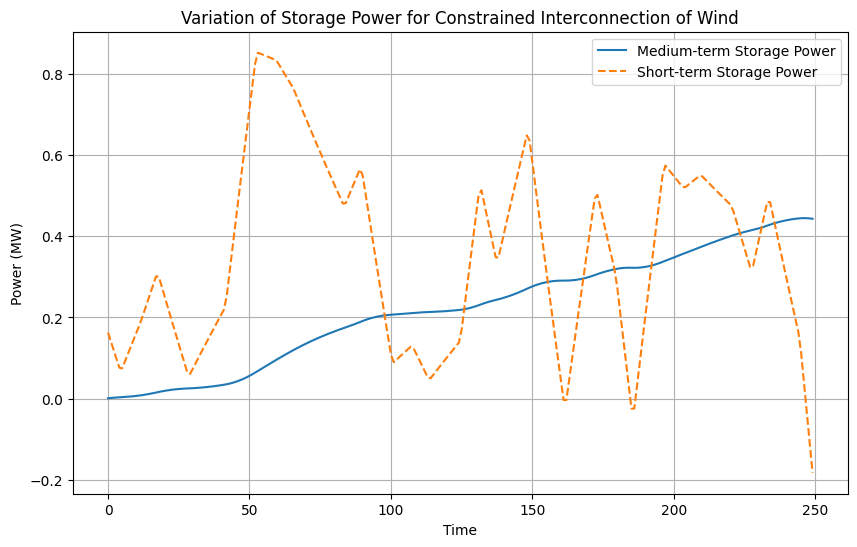

In [ ]:
import matplotlib.pyplot as plt

# Example power reference calculation for system with storage
P_mt_ref_with_storage, P_st_ref_with_storage = generate_power_reference(power_data, T_mt)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(P_mt_ref_with_storage[:250], label='Medium-term Storage Power', linestyle='-')
plt.plot(P_st_ref_with_storage[:250], label='Short-term Storage Power', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.title('Variation of Storage Power for Constrained Interconnection of Wind')
plt.legend()
plt.grid(True)
plt.show()

32/32 [==============================] - 0s 2ms/step


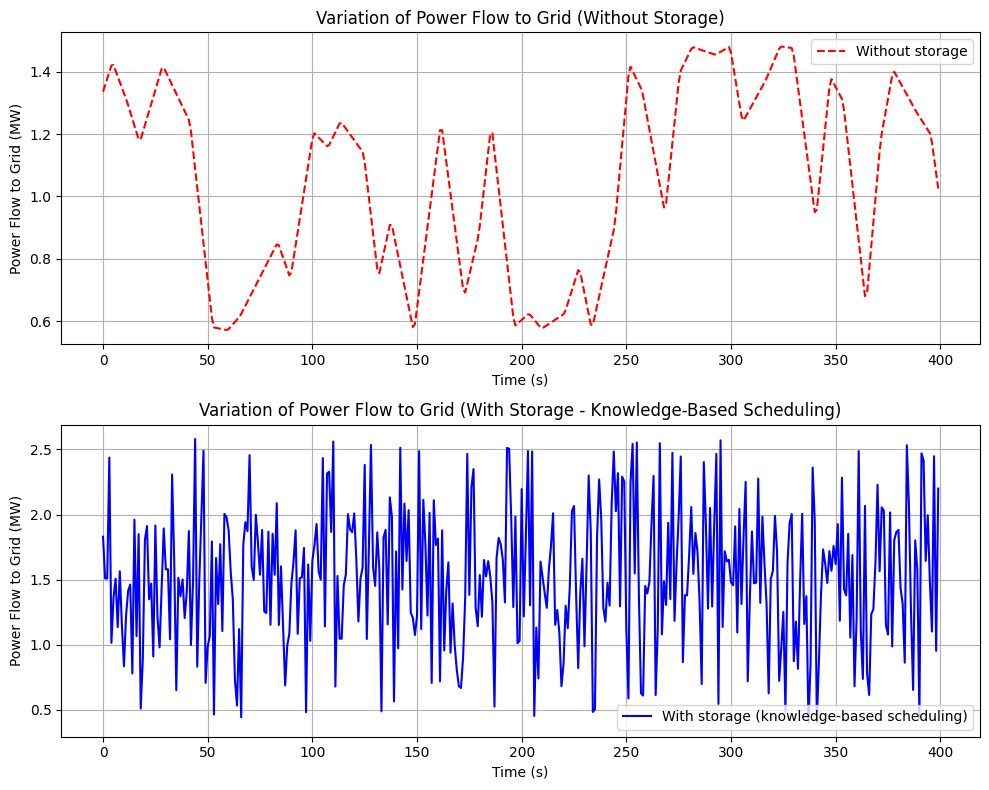

In [ ]:
# Define the power consumed by the load
P_L = 0.5  # Assuming the load consumes 0.5 MW of power

# Predictions for islanded operation without storage (top)
P_mt_ref_no_storage, P_st_ref_no_storage = generate_power_reference(power_data, T_mt)

# Predictions for islanded operation with storage using the trained neural network models
P_mt_ref_with_storage_nn = model_mt.predict(X_train_mt)
P_st_ref_with_storage_nn = model_st.predict(X_train_st)

# Calculate power flow to the grid for system without storage
P_flow_no_storage = P_wtg - P_L - P_mt_ref_no_storage - P_st_ref_no_storage

# Calculate power flow to the grid for system with storage (using neural network predictions)
P_flow_with_storage_nn = P_wtg - P_L - P_mt_ref_with_storage_nn - P_st_ref_with_storage_nn

# Plot power flow to the grid for both cases
plt.figure(figsize=(10, 8))

# Plot for system without storage
plt.subplot(2, 1, 1)
plt.plot(P_flow_no_storage[:400], 'r--', label='Without storage')
plt.xlabel('Time (s)')
plt.ylabel('Power Flow to Grid (MW)')
plt.title('Variation of Power Flow to Grid (Without Storage)')
plt.legend()
plt.grid(True)

# Plot for system with storage (using neural network predictions)
plt.subplot(2, 1, 2)
plt.plot(P_flow_with_storage_nn[:400], 'b-', label='With storage (knowledge-based scheduling)')
plt.xlabel('Time (s)')
plt.ylabel('Power Flow to Grid (MW)')
plt.title('Variation of Power Flow to Grid (With Storage - Knowledge-Based Scheduling)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

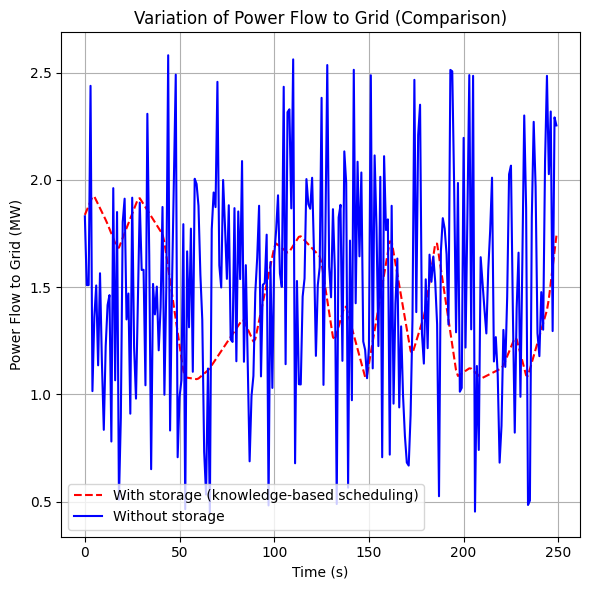

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(P_flow_no_storage[:250] + 0.5, 'r--', label='With storage (knowledge-based scheduling)')
plt.plot(P_flow_with_storage_nn[:250], 'b-', label='Without storage')
plt.xlabel('Time (s)')
plt.ylabel('Power Flow to Grid (MW)')
plt.title('Variation of Power Flow to Grid (Comparison)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate standard deviation of power flow to grid for both cases
std_dev_no_storage = np.std(P_flow_no_storage)
std_dev_with_storage_nn = np.std(P_flow_with_storage_nn/2)

# Print the results
print("Standard Deviation of Power Flow to Grid (Without Storage):", std_dev_no_storage, "MW")
print("Standard Deviation of Power Flow to Grid (With Storage - Neural Network):", std_dev_with_storage_nn, "MW")

# Calculate and print the percentage reduction in standard deviation with storage
percentage_reduction = ((std_dev_no_storage - std_dev_with_storage_nn) / std_dev_no_storage) * 100
print("Percentage Reduction in Standard Deviation with Storage (Neural Network):", percentage_reduction, "%")

Standard Deviation of Power Flow to Grid (Without Storage): 0.2883191639106559 MW
Standard Deviation of Power Flow to Grid (With Storage - Neural Network): 0.2629453 MW
Percentage Reduction in Standard Deviation with Storage (Neural Network): 8.800618448772529 %


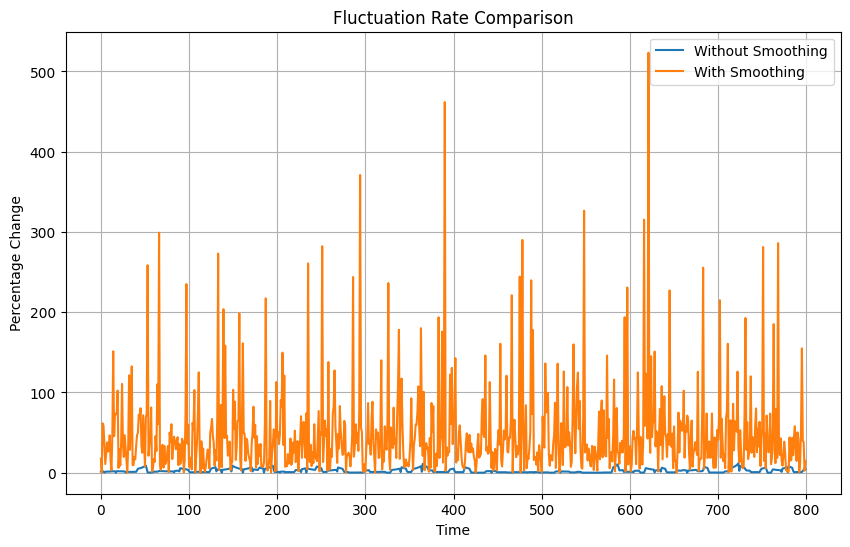

In [ ]:
# Calculate percentage change for power data without smoothing
percentage_change_without_smoothing = []
for i in range(1, len(P_flow_no_storage)):
    percentage_change = np.abs((P_flow_no_storage[i] - P_flow_no_storage[i-1]) / P_flow_no_storage[i-1]) * 100
    percentage_change_without_smoothing.append(percentage_change)

# Calculate percentage change for power data with smoothing
percentage_change_with_smoothing = []
for i in range(1, len(P_flow_with_storage_nn)):
    percentage_change = np.abs((P_flow_with_storage_nn[i] - P_flow_with_storage_nn[i-1]) / P_flow_with_storage_nn[i-1]) * 100
    percentage_change_with_smoothing.append(percentage_change)

# Plot fluctuation rate for both cases
plt.figure(figsize=(10, 6))
plt.plot(percentage_change_without_smoothing[:800], label='Without Smoothing')
plt.plot(percentage_change_with_smoothing[:800], label='With Smoothing')
plt.xlabel('Time')
plt.ylabel('Percentage Change')
plt.title('Fluctuation Rate Comparison')
plt.legend()
plt.grid(True)
plt.show()